# Experiments implementing neural networks by hand

In [5]:
import numpy as np
from numpy import random as rnd
from pyclugen import clugen
import matplotlib.pyplot as plt
import time
from PIL import Image
from pathlib import Path
from mynn import *

## Create train and test data with pyclugen

Text(0.5, 0.92, 'Test data')

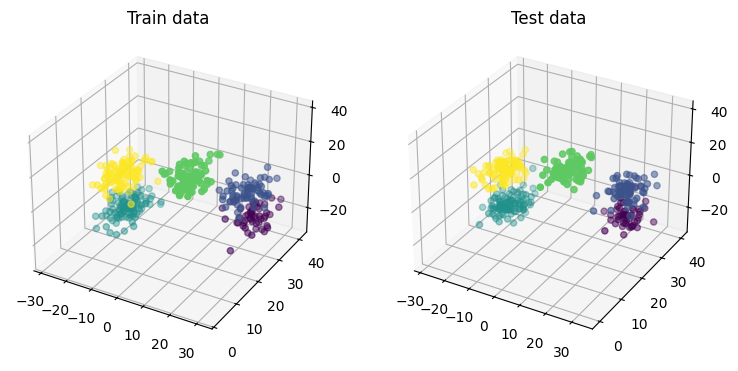

In [6]:
# Clugen parameters
ndims = 3
seed = 123
nclu = 5
npts = 400
direction = [1, 1, 0.5]
angstd = np.pi / 4
csep = [15, 15, 15]
llen = 0.1
llen_std = 0
fat = 3.5

# Generate train data
data_train = clugen(
    ndims,
    nclu,
    npts,
    direction,
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed),
)

# Generate test data, based on parameters from train data
data_test = clugen(
    ndims,
    nclu,
    npts * 2,
    data_train.directions,  # Use final directions in the train data
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed * 9 - 27),
    # Use final values from the train data
    clusizes_fn=data_train.sizes,
    clucenters_fn=data_train.centers,
    llengths_fn=data_train.lengths,
)

# Plot the train and test data
_, axs = plt.subplots(1, 2, figsize=(9, 6), subplot_kw=dict(projection="3d"))
axs[0].scatter(
    data_train.points[:, 0],
    data_train.points[:, 1],
    data_train.points[:, 2],
    c=data_train.clusters,
)
axs[0].set_title("Train data")
axs[1].scatter(
    data_test.points[:, 0],
    data_test.points[:, 1],
    data_test.points[:, 2],
    c=data_test.clusters,
)
axs[1].set_title("Test data")

## Experiments

In [7]:
# Value that output nodes are expected to have when activated or otherwise
# assuming 1-of-n output encoding
node_off = 0.1
node_on = 0.9

# Convert output to appropriate NN format output
clunn_train, _ = categ2oneofn(data_train.clusters, node_off, node_on)
clunn_test, _ = categ2oneofn(data_test.clusters, node_off, node_on)

### Quickly compare loop-based and vectorized versions of backpropagation and inference

Backpropagation using loops: 18.383839266 seconds
Vectorized backpropagation : 7.547635207 seconds
Vectorization speedup vs loop-based : 2.44x


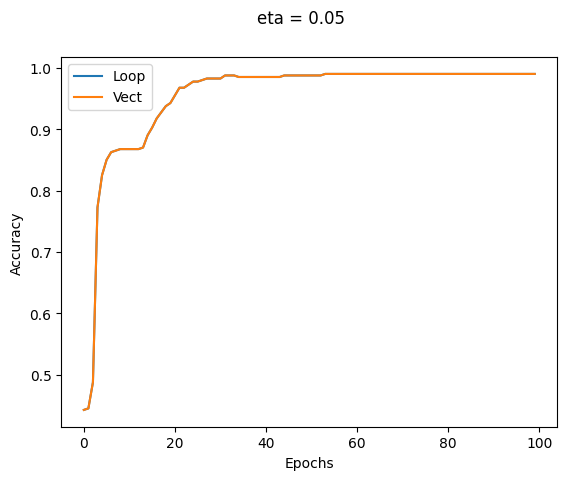

In [8]:
# Backpropagation parameters
epochs = 100
eta = 0.05
mom = 0.1
topol = [ndims, 12, nclu]

# Prepare hooks for registering accuracy
fitreg_loop = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)
fitreg_vect = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)

# Test loop-based backpropagation
time_start = time.time_ns()
backpropagation(
    data_train.points, clunn_train, topol, epochs, eta, mom, hooks=[fitreg_loop]
)
duration_loop = time.time_ns() - time_start
print(f"Backpropagation using loops: {duration_loop / 1e9} seconds")

# Test vectorized backpropagation
time_start = time.time_ns()
vbackpropagation(
    data_train.points, clunn_train, topol, epochs, eta, mom, hooks=[fitreg_vect]
)
duration_vect = time.time_ns() - time_start
print(f"Vectorized backpropagation : {duration_vect / 1e9} seconds")

# Speedup loop-based vs vectorized
print(f"Vectorization speedup vs loop-based : {duration_loop / duration_vect:.2f}x")

# Plot accuracy
plot_metric(
    epochs,
    {
        "Loop": fitreg_loop.accuracies,
        "Vect": fitreg_vect.accuracies,
    },
    "Accuracy",
    f"eta = {eta}",
)

### Train with train data, determine accuracy with test data

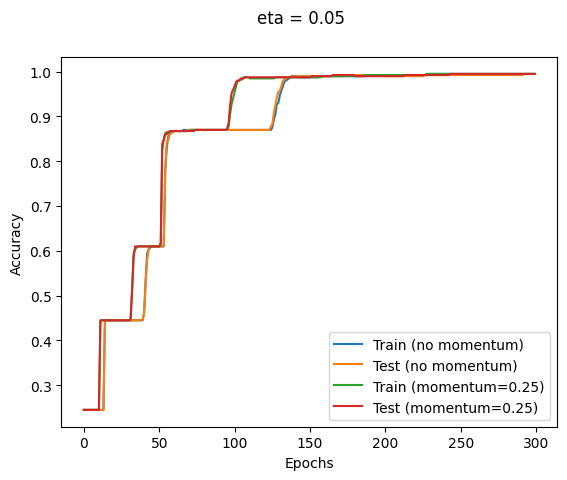

In [9]:
# Backpropagation parameters
epochs = 300
eta = 0.05
mom = 0.25
topol = [ndims, 18, 18, nclu]

# Prepare hooks for registering accuracy
fitreg_train = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)
fitreg_test = AccuracyRegister(data_test.points, clunn_train, epochs, node_off, node_on)
fitreg_train_m = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)
fitreg_test_m = AccuracyRegister(
    data_test.points, clunn_train, epochs, node_off, node_on
)

# Perform backpropagation without and with momentum
nn1 = vbackpropagation(
    data_train.points,
    clunn_train,
    topol,
    epochs,
    eta,
    hooks=[fitreg_train, fitreg_test],
)
nn2 = vbackpropagation(
    data_train.points,
    clunn_train,
    topol,
    epochs,
    eta,
    mom,
    hooks=[fitreg_train_m, fitreg_test_m],
)

# Plot accuracy
plot_metric(
    epochs,
    {
        "Train (no momentum)": fitreg_train.accuracies,
        "Test (no momentum)": fitreg_test.accuracies,
        f"Train (momentum={mom})": fitreg_train_m.accuracies,
        f"Test (momentum={mom})": fitreg_test_m.accuracies,
    },
    "Accuracy",
    f"eta = {eta}",
)